In [1]:
# change into the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')

%load_ext autoreload
%autoreload 2

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
!pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np

# a nice color map
plt.rcParams['image.cmap'] = 'plasma'


!pip install neurolib
from neurolib.models.aln import ALNModel
from neurolib.utils.loadData import Dataset
ds = Dataset("hcp")

import mopet


!rm exploration.h5

#model = ALNModel(Cmat = ds.Cmat, Dmat = ds.Dmat)
model = ALNModel()
model.params.duration = 1*1000
    
def evalFunction(params):
    model.params.update(params)
    model.run()
    return model.outputs

params = model.params
explore_params = {"mue_ext_mean" : np.linspace(0, 3, 31),
                  "mui_ext_mean" : np.linspace(0, 3, 31)}
ex = mopet.Exploration(evalFunction, explore_params, default_params=params)

INFO:root:Loading dataset hcp from /Users/caglar/anaconda/lib/python3.7/site-packages/neurolib/utils/../data/datasets/hcp.
INFO:root:Dataset hcp loaded.
INFO:root:aln: Model initialized.


In [3]:
ex.run()

2020-03-13 03:30:57,591	INFO resource_spec.py:212 -- Starting Ray with 3.86 GiB memory available for workers and up to 1.93 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-03-13 03:30:58,175	INFO services.py:1093 -- View the Ray dashboard at localhost:8266
INFO:root:Runs took 20.913066148757935 s to submit.
100%|██████████| 961/961 [00:03<00:00, 305.00it/s]
INFO:root:Runs and storage took 3.152482032775879 s to complete.


In [4]:
ex.load_results()

INFO:root:exploration.h5 opened for reading.
INFO:root:Gettings runs of exploration ``exploration_2020_03_13_03H_30M_57S``
INFO:root:961 results loaded.
INFO:root:Creating new results DataFrame
INFO:root:exploration.h5 closed.


In [5]:
ex.results

{0: {'rates_exc': array([[26.15770656, 24.06801404, 22.19195939, ...,  0.03552955,
           0.03553114,  0.03553274]]),
  'rates_inh': array([[6.37942674e+01, 5.83096860e+01, 5.37860359e+01, ...,
          3.78226301e-02, 3.78230757e-02, 3.78235211e-02]]),
  't': array([1.000e-01, 2.000e-01, 3.000e-01, ..., 9.998e+02, 9.999e+02,
         1.000e+03])},
 1: {'rates_exc': array([[2.61577066e+01, 2.40680140e+01, 2.21919594e+01, ...,
          2.30228697e-02, 2.30236701e-02, 2.30244702e-02]]),
  'rates_inh': array([[63.79426742, 58.30968605, 53.79363145, ...,  0.10615402,
           0.10615446,  0.10615491]]),
  't': array([1.000e-01, 2.000e-01, 3.000e-01, ..., 9.998e+02, 9.999e+02,
         1.000e+03])},
 10: {'rates_exc': array([[2.61577066e+01, 2.40680140e+01, 2.21919594e+01, ...,
          4.47863259e-08, 4.47885663e-08, 4.47908057e-08]]),
  'rates_inh': array([[63.79426742, 58.30968605, 53.86199139, ...,  2.28951659,
           2.28951659,  2.28951659]]),
  't': array([1.000e-01, 2.0

In [6]:
ex.df["result"] = None
for r in ex.df.index:
    t = ex.results[r]['t']    
    rates_exc = ex.results[r]['rates_exc']
    ex.df.loc[r, "result"] = np.max(rates_exc[:, t>500])

In [7]:
ex.df

,mue_ext_mean,mui_ext_mean,result
0,0,0,0.0355327
1,0,0.1,0.0230245
10,0,1,4.47908e-08
100,0.3,0.7,0.00575565
101,0.3,0.8,0.00123482
...,...,...,...
96,0.3,0.3,0.766613
960,3,3,63.3969
97,0.3,0.4,0.225154
98,0.3,0.5,0.0702888


In [8]:
pivoted = ex.df.pivot_table(values='result', index = 'mui_ext_mean', columns='mue_ext_mean', aggfunc='first')

Text(0, 0.5, 'Input to I')

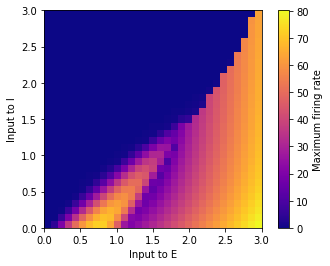

In [9]:
plt.imshow(pivoted, \
           extent = [min(ex.df.mue_ext_mean), max(ex.df.mue_ext_mean),
                     min(ex.df.mui_ext_mean), max(ex.df.mui_ext_mean)], origin='lower')
plt.colorbar(label='Maximum firing rate')
plt.xlabel("Input to E")
plt.ylabel("Input to I")